<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/fyp_model_training_GCC_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=2c44ddb56f4931982f47767aa76cbe6e3672ff2ecd4771c8c14586d47ce9b09c
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.3 GB  | Proc size: 118.5 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [4]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import glob
from sklearn.model_selection import train_test_split
import json

import sys
import warnings
# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torchvision import models

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
      x = self.conv(x)
      if self.bn is not None:
          x = self.bn(x)
      if self.relu is not None:
          x = self.relu(x)   
      return x
  
# the module definition for the multi-branch in the density head
class MultiBranchModule(nn.Module):
    def __init__(self, in_channels, sync=False):
        super(MultiBranchModule, self).__init__()
        self.branch_column1_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column1_2 = BasicConv2d(in_channels//2, in_channels, kernel_size=1, sync=sync)

        self.branch_column2_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column2_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=(3, 3), padding=(1, 1), sync=sync)

        self.branch_column3_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column3_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=5, padding=2, sync=sync)

    def forward(self, x):
        branch_1 = self.branch_column1_1(x)
        branch_1 = self.branch_column1_2(branch_1)

        branch_2 = self.branch_column2_1(x)
        branch_2 = self.branch_column2_2(branch_2)

        branch_3 = self.branch_column3_1(x)
        branch_3 = self.branch_column3_2(branch_3)

        outputs = [branch_1, branch_2, branch_3, x]
        return torch.cat(outputs, 1)

# the module definition for the basic conv module
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, sync=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        if sync:
            # for sync bn
            print('use sync inception')
            self.bn = nn.SyncBatchNorm(out_channels, eps=0.001)
        else:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [6]:
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    gt_path = img_path.replace('.png','.h5').replace('pngs','GT')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path, 'r')
    target = np.asarray(gt_file['density'])
    target = cv2.resize(target,(int(target.shape[1]/2.25), int(target.shape[0]/2.25)),interpolation = cv2.INTER_CUBIC)*5.06448
    return img,target
"""
create a list of file (full directory)
"""

def create_training_image_list(data_path):
    """
    create a list of absolutely path of jpg file
    :param data_path: must contain subfolder "images" with *.png  (example ShanghaiTech/part_A/train_data/)
    :return:
    """
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "pngs", "*.png"))
    return image_path_list


def get_train_val_list(data_path):
    DATA_PATH = data_path
    scences = ['scene_00_0','scene_00_1','scene_00_2','scene_00_1','scene_01_0','scene_01_1','scene_01_2','scene_01_3',
               'scene_02_0','scene_02_1','scene_02_2','scene_02_3','scene_03_0','scene_03_1','scene_03_2','scene_03_3',
               'scene_04_0','scene_04_1','scene_04_2','scene_04_3','scene_05_0','scene_05_1','scene_05_2','scene_05_3',
               'scene_06_0','scene_06_1','scene_06_2','scene_06_3','scene_07_0','scene_07_1','scene_07_2','scene_07_3',
               'scene_08_0','scene_08_1','scene_08_2','scene_08_3','scene_09_0','scene_09_1','scene_09_2','scene_09_3']
    image_path_list = []
    for scene in scences:
      image_path_list += glob.glob(os.path.join(DATA_PATH,scene, "pngs", "*.png"))
    train, val = train_test_split(image_path_list, test_size=0.1)

    print("train size ", len(train))
    print("val size ", len(val))
    return train, val




class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None,  train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)
        
        #img = 255.0 * F.to_tensor(img)
        
        #img[0,:,:]=img[0,:,:]-92.8207477031
        #img[1,:,:]=img[1,:,:]-95.2757037428
        #img[2,:,:]=img[2,:,:]-104.877445883
        if self.transform is not None:
            img = self.transform(img)
        return img,target
  

In [7]:
class TestNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(512 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) 

        # Multi-Branch moules
        self.multi_branch5 = nn.Sequential(
            MultiBranchModule(512),
            Conv2d(2048, 1, 1, same_padding=True)
        )

        self.multi_branch4 = nn.Sequential(
            MultiBranchModule(256),
            Conv2d(1024, 1, 1, same_padding=True)
        )

        self.multi_branch3 = nn.Sequential(
            MultiBranchModule(128),
            Conv2d(512, 1, 1, same_padding=True)
        )

        self.multi_branch2 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.multi_branch1 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.backend = make_layers(self.backend_feat,in_channels = 5,dilation = True)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x


        # multi-branch predictions
        x5_density = self.multi_branch5(x5_out)
        x4_density = self.multi_branch4(x4_out)
        x3_density = self.multi_branch3(x3_out)
        x2_density = self.multi_branch2(x2_out)
        x1_density = self.multi_branch1(x1_out)

        # upsample the multi-branch predictions to be the same with the input size
        x5_density = F.upsample_nearest(x5_density, size=x1.size()[2:])
        x4_density = F.upsample_nearest(x4_density, size=x1.size()[2:])
        x3_density = F.upsample_nearest(x3_density, size=x1.size()[2:])
        x2_density = F.upsample_nearest(x2_density, size=x1.size()[2:])
        x1_density = F.upsample_nearest(x1_density, size=x1.size()[2:])


        density_map = torch.cat([x5_density, x4_density, x3_density, x2_density, x1_density], 1)


        x_out = self.backend(density_map)
        density_map_out = self.output_layer(x_out)
        return density_map_out
        #return density_map
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    layers = []
    dilation_rates = [2,3,5]
    #for v in cfg:
    for v in range(len(cfg)):
        if cfg[v] == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg[v], kernel_size=3, padding=dilation_rates[v],dilation = dilation_rates[v])
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(cfg[v]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg[v]
    return nn.Sequential(*layers)

In [8]:
model = TestNet()
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [14]:
def get_image_path(file_path):
  file_path_list = file_path.split(" ")
  scene = file_path_list[3][4:]
  image_number = file_path_list[4]
  image_path = "/content/drive/MyDrive/GCC/"+"Part"+" "+scene[7]+scene+"/"+"pngs/"+image_number+".png"
  return image_path
  
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_

def extract_image_path_list(image_file, part):
  file_ = open(image_file, 'r')
  file_list = file_.readlines()
  image_path_list_train = []  
  for line in file_list:
      image_path_list_train.append(get_image_path(line))
  train_list = get_image_pathlist(image_path_list_train, part)
  print("train size: ",len(train_list))
  return train_list



In [20]:
train_list = '/content/drive/MyDrive/GCC/train_list.txt'
part1_train_list = extract_image_path_list(train_list, "Part 1")
part1_train_list[0:2]

train size:  1160


['/content/drive/MyDrive/GCC/Part 1/scene_10_0/pngs/1531114771.png',
 '/content/drive/MyDrive/GCC/Part 1/scene_10_0/pngs/1531114611.png']

In [21]:
test_list = '/content/drive/MyDrive/GCC/test_list.txt'
part1_test_list = extract_image_path_list(test_list, "Part 1")
part1_test_list[0:2]

train size:  385


['/content/drive/MyDrive/GCC/Part 1/scene_10_0/pngs/1531114578.png',
 '/content/drive/MyDrive/GCC/Part 1/scene_10_0/pngs/1531114596.png']

In [22]:
train_loader = torch.utils.data.DataLoader(ListDataset(part1_train_list,
                                                                shuffle=True,
                                                                transform=transforms.Compose([
                                                                    transforms.ToTensor(), transforms.Resize(480),transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                train=True,
                                                                batch_size=2,
                                                                num_workers=2),batch_size=2)

In [23]:
test_loader = torch.utils.data.DataLoader(ListDataset(part1_test_list,
                                  shuffle=False,
                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(480),transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                  std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                  ]), train=False,batch_size=2,num_workers=2),
              batch_size=2)

In [24]:
lr = 1e-5
criterion = nn.MSELoss(size_average=False).cuda()

#optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.95,weight_decay=5 * 1e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [25]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [41]:
PATH = '/content/drive/MyDrive/GCC/TestNet_checkpoint_Part1_1.pth'
epoch = 24
start_epoch = 0
if (os.path.isfile(PATH))==True:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  print("Successfully load the check point")
else:
  print("No check point Available!!!")

Successfully load the check point


In [42]:
print(epoch , start_epoch)

24 22


In [28]:
PATH = '/content/drive/MyDrive/GCC/TestNet_checkpoint_Part1_1.pth'

In [43]:
for epoch in range(start_epoch,epoch):
    mae_train = 0
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    model.train()
    end = time.time()
    loss_list = []
    mae_list =[]
    best_predict_mae = 2000
    for i, (img, target) in enumerate(train_loader):

        img = img.cuda()
        img = Variable(img)

        output = model(img)
        target = target.type(torch.FloatTensor).unsqueeze(1).cuda()
        target = Variable(target)


        #backword
        loss = criterion(output, target)
        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()


        #calculate the MAE values
        pred_map = output.data.cpu().numpy()
        gt_map = target.data.cpu().numpy()
        mae_train += abs(np.sum(pred_map) -np.sum(gt_map))

        if i % 50 == 0:
            print('Epoch : {}, train MAE : {}'.format(epoch, mae_train/len(train_loader)))
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                .format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))
    
    scheduler.step()  
    mae_list.append(mae_train / len(train_loader))
    loss_list.append(loss)
    mae_train = mae_train / len(train_loader)
    print(' * TRAINING MAE {mae:.3f} '.format(mae=mae_train)) 
    torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)       
MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC/GCC_part1.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Epoch : 22, train MAE : 0.2730177254512392
Epoch: [22][0/580]	Time 3.666 (3.666)	Data 0.000 (0.000)	Loss 81.4440 (81.4440)	
Epoch : 22, train MAE : 24.5724340767696
Epoch: [22][50/580]	Time 3.556 (3.571)	Data 0.000 (0.000)	Loss 1.4684 (28.9733)	
Epoch : 22, train MAE : 37.27109899849727
Epoch: [22][100/580]	Time 3.556 (3.574)	Data 0.000 (0.000)	Loss 8.7705 (21.1488)	
Epoch : 22, train MAE : 45.407820997567015
Epoch: [22][150/580]	Time 3.558 (3.573)	Data 0.000 (0.000)	Loss 14.7104 (19.0860)	
Epoch : 22, train MAE : 51.9617439927726
Epoch: [22][200/580]	Time 3.560 (3.572)	Data 0.000 (0.000)	Loss 1.6820 (17.6153)	
Epoch : 22, train MAE : 57.60586165066423
Epoch: [22][250/580]	Time 3.562 (3.572)	Data 0.000 (0.000)	Loss 14.3340 (17.3157)	
Epoch : 22, train MAE : 64.02288985416807
Epoch: [22][300/580]	Time 3.558 (3.575)	Data 0.000 (0.000)	Loss 12.7838 (16.7880)	
Epoch : 22, train MAE : 69.81871560195397
Epoch: [22][350/580]	Time 3.557 (3.577)	Data 0.000 (0.000)	Loss 0.4004 (17.1408)	
Epoch :

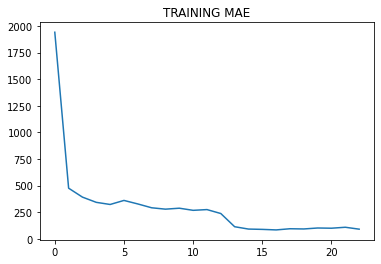

In [44]:
import matplotlib.pyplot as plt
import numpy as np
def plot(xpoints,ypoints,title):
  plt.plot(xpoints, ypoints)
  plt.title(title)
  plt.show()

xpoints = [*range(0, epoch, 1)]
ypoints = [1941,476,392,343,323,361,328,292,279,288,268,275,238,114, 92, 89, 84, 95, 93 , 102, 100, 109, 91]
plot(xpoints, ypoints, "TRAINING MAE")

In [45]:
model_path = '/content/drive/MyDrive/GCC/GCC_part1.pth'

model = TestNet().cuda()
# load the trained model
model.load_state_dict(torch.load(model_path))
print('successfully load model from', model_path)


with torch.no_grad():
  model.eval()
  mae = 0

  for i, (img, target) in enumerate(test_loader):
      img = img.cuda()
      img = Variable(img)   
      output = model(img)


      pred_map = output.data.cpu().numpy()
      gt_map = target.data.cpu().numpy()
      print("Model Predicted Count", np.sum(pred_map))
      print("Ground Trueth Count", np.sum(gt_map))

      mae += abs(np.sum(pred_map) -np.sum(gt_map))

  mae = mae / len(test_loader)
  print(' * TESTING MAE {mae:.3f} '.format(mae=mae))

successfully load model from /content/drive/MyDrive/GCC/GCC_part1.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Model Predicted Count 50.05838
Ground Trueth Count 142.75102
Model Predicted Count 14.758515
Ground Trueth Count 160.72224
Model Predicted Count 306.49664
Ground Trueth Count 326.9262
Model Predicted Count 285.93512
Ground Trueth Count 430.48
Model Predicted Count 243.05273
Ground Trueth Count 280.38525
Model Predicted Count -19.50903
Ground Trueth Count 151.05339
Model Predicted Count 0.6026802
Ground Trueth Count 168.16994
Model Predicted Count -97.98638
Ground Trueth Count 72.14069
Model Predicted Count -132.31142
Ground Trueth Count 25.0146
Model Predicted Count 47.99741
Ground Trueth Count 211.46396
Model Predicted Count 156.25594
Ground Trueth Count 304.09363
Model Predicted Count 1.4081526
Ground Trueth Count 160.05145
Model Predicted Count 113.57413
Ground Trueth Count 278.636
Model Predicted Count -38.68021
Ground Trueth Count 144.24098
Model Predicted Count 160.14507
Ground Trueth Count 347.47336
Model Predicted Count 260.3151
Ground Trueth Count 429.54706
Model Predicted Cou

In [69]:
model_path = '/content/drive/MyDrive/GCC/GCC_part1.pth'

model = TestNet().cuda()
# load the trained model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

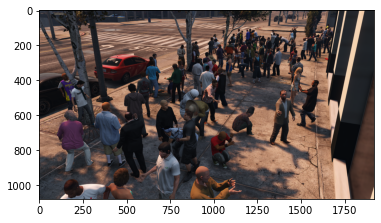

In [73]:
img_path = "/content/drive/MyDrive/GCC/Part 1/scene_11_3/pngs/1531175876.png"
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import PIL.Image as Image
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_path))

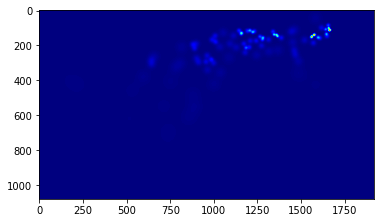

In [74]:
density_map_path = "/content/drive/MyDrive/GCC/Part 1/scene_11_3/GT/1531175876.h5"
import h5py
gt_file = h5py.File(density_map_path,'r')
groundtruth = np.asarray(gt_file['density'])

plt.imshow(groundtruth,cmap=CM.jet)

In [75]:
np.sum(groundtruth)

97.45222

In [76]:
im = Image.open(img_path)

In [77]:
pred_transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(480), transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                std=[0.227743327618, 0.211051672697, 0.184846073389]),])



In [78]:
pred = model(pred_transform(im)[None].cuda())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


In [79]:
pred = pred.cpu()
pred = pred.detach().numpy()
np.sum(pred)

348.78214

In [53]:
groundtruth

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.2409831e-08,
        5.1109467e-08, 4.9818805e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.8516796e-08,
        4.7313019e-08, 4.6118231e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.4892605e-08,
        4.3778751e-08, 4.2673211e-08]], dtype=float32)

In [65]:
pred

array([[[[-7.5627491e-04, -2.3324192e-03,  3.8283318e-04, ...,
           6.2618032e-04,  8.2938373e-04,  1.4058910e-03],
         [-3.3034384e-04, -3.4219660e-03, -2.0026378e-03, ...,
           2.2112206e-04,  3.9127097e-04,  8.0212951e-04],
         [-2.8449409e-03, -3.4141392e-03, -3.3125281e-05, ...,
          -1.0431521e-03,  2.9683858e-04,  1.0756403e-04],
         ...,
         [-4.1611493e-05, -6.7243353e-04, -2.4365261e-04, ...,
           2.1038949e-04,  7.4216351e-04,  3.9860606e-07],
         [-8.0530718e-04, -4.6099350e-04, -1.2068003e-03, ...,
           6.5881014e-04,  3.7694350e-04,  1.7866567e-03],
         [-7.4456632e-04, -7.2891265e-04, -1.6644485e-03, ...,
           4.5947731e-04,  1.2358576e-03,  1.7265044e-03]]]],
      dtype=float32)

2370.8547

In [ ]:
#cv2.imwrite('pred4.jpg',groundtruth)

True

In [67]:
import matplotlib

matplotlib.image.imsave('pred2.png', pred[0][0])

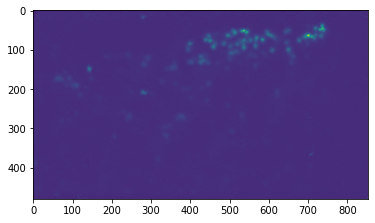

In [68]:
import matplotlib.pyplot as plt
img_path = "./pred2.png"
im = Image.open(img_path)
plt.imshow(im,cmap=CM.jet)

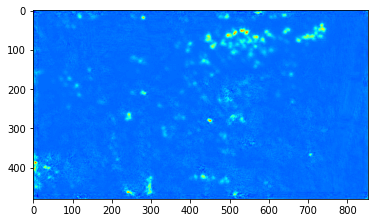

In [80]:
 
#im =  np.asarray(im)
plt.imshow(pred[0][0],cmap=CM.jet)

In [81]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


Gen RAM Free: 24.1 GB  | Proc size: 3.3 GB
GPU RAM Free: 1575MB | Used: 14705MB | Util  90% | Total 16280MB


In [ ]:
import torch, gc
#with torch.no_grad():
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   12232 MB |   14632 MB |   19368 MB |    7136 MB |\n|       from large pool |   12224 MB |   14624 MB |   19351 MB |    7127 MB |\n|       from small pool |       7 MB |       8 MB |      16 MB |       8 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   12232 MB |   14632 MB |   19368 MB |    7136 MB |\n|       from large pool |   12224 MB |   14624 MB |